In [1]:
!pip install -U evaluate
!pip install -U datasets
!pip install -U accelerate
!pip install -U transformers

In [2]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline, create_optimizer, DataCollatorWithPadding
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
import evaluate

import csv
from collections import defaultdict

In [3]:
OUTPUT_DIR = 'output'
VAL_RATIO = 0.3
DATA_COLUMNS = ['title', 'word_count', 'character_count', 'bigrams', 'lemma', 'pos', 'tag', 'dep', 'label', 'context_score', 'trigger_words']
LABEL_COLUMN = 'category'
DATASET_DIR = 'data/output_with_category.csv'

## Load Dataset

In [4]:
def load_dataset(file_location, target_column):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_location)
    labels = sorted(list(df[target_column].unique()))
    print(len(labels))

    #convert labels in target column to numbers
    df[target_column] = df[target_column].apply(lambda x: labels.index(x))

    return df, labels

In [5]:
data_df, label_list = load_dataset(DATASET_DIR, LABEL_COLUMN)

14


In [6]:
train_data, test_data = train_test_split(data_df, test_size=0.25, stratify=data_df[LABEL_COLUMN])

In [7]:
print(len(set(train_data[LABEL_COLUMN])))
print(len(set(test_data[LABEL_COLUMN])))

14
14


In [8]:
data_df.head()

,title,word_count,character_count,bigrams,lemma,pos,tag,dep,label,context_score,trigger_words,category
0,2006 Pangandaran earthquake and tsunami,5,39,"[('2006', 'Pangandaran'), ('Pangandaran', 'ear...","['2006', 'Pangandaran', 'earthquake', 'and', '...","['NUM', 'PROPN', 'NOUN', 'CCONJ', 'NOUN']","['CD', 'NNP', 'NN', 'CC', 'NN']","['nummod', 'compound', 'ROOT', 'cc', 'conj']","['DATE', '', '', '', '']","{'pangandaran': 0.04385272437177429, 'earthqua...","['pangandaran', 'earthquake', 'tsunami']",5
1,Battle of Santa Clara (1927),5,28,"[('Battle', 'of'), ('of', 'Santa'), ('Santa', ...","['battle', 'of', 'Santa', 'Clara', '1927']","['NOUN', 'ADP', 'PROPN', 'PROPN', 'NUM']","['NN', 'IN', 'NNP', 'NNP', 'CD']","['ROOT', 'prep', 'compound', 'pobj', 'appos']","['', '', 'GPE', 'GPE', 'DATE']","{'battle': 1.0, 'santa_clara': 0.0}","['battle', 'santa_clara']",9
2,Siege of Pondicherry (1793),4,27,"[('Siege', 'of'), ('of', 'Pondicherry'), ('Pon...","['siege', 'of', 'Pondicherry', '1793']","['NOUN', 'ADP', 'PROPN', 'NUM']","['NN', 'IN', 'NNP', 'CD']","['ROOT', 'prep', 'pobj', 'appos']","['', '', '', 'DATE']","{'siege': 1.0, 'pondicherry': 0.02664499418035...","['siege', 'pondicherry']",1
3,Battle of Leuthen,3,17,"[('Battle', 'of'), ('of', 'Leuthen')]","['battle', 'of', 'Leuthen']","['NOUN', 'ADP', 'PROPN']","['NN', 'IN', 'NNP']","['ROOT', 'prep', 'pobj']","['', '', '']","{'battle': 1.0, 'leuthen': 0.012009661111137613}","['battle', 'leuthen']",9
4,Glasgow St Enoch rail accident,5,30,"[('Glasgow', 'St'), ('St', 'Enoch'), ('Enoch',...","['Glasgow', 'St', 'Enoch', 'rail', 'accident']","['PROPN', 'PROPN', 'PROPN', 'NOUN', 'NOUN']","['NNP', 'NNP', 'NNP', 'NN', 'NN']","['compound', 'compound', 'compound', 'compound...","['GPE', 'GPE', 'GPE', '', '']","{'glasgow_st_enoch': 0.0, 'rail': 1.0, 'accide...","['glasgow_st_enoch', 'rail', 'accident']",1


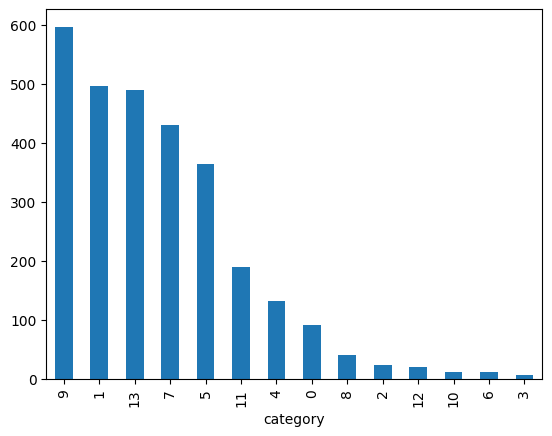

In [9]:
# @title category

from matplotlib import pyplot as plt

def plot_category_distribution(data_df):
    category_counts = data_df['category'].value_counts()
    category_counts.plot(kind='bar')
    plt.show()

plot_category_distribution(data_df)

In [10]:
print('Length of labels:', len(label_list))
print('Shape of the training data: ', train_data.shape)
print('Shape of the test data: ', test_data.shape)

Length of labels: 14
Shape of the training data:  (2181, 12)
Shape of the test data:  (728, 12)


In [11]:
model_checkpoint = "distilbert-base-uncased"
max_length = 128

# Load BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [20]:
import tensorflow as tf

def preprocess_function(input_data):
    titles = input_data['title'].tolist()

    # Tokenize each title separately
    tokenized_inputs = tokenizer(titles, padding=True, truncation=True, max_length=max_length)

    # Convert lists to TensorFlow tensors
    input_ids = tf.constant(tokenized_inputs['input_ids'])
    attention_mask = tf.constant(tokenized_inputs['attention_mask'])
    labels = tf.constant(input_data[LABEL_COLUMN].tolist())

    # Create a TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices(({
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }, labels))

    return dataset

In [24]:
encoded_train = preprocess_function(train_data)
encoded_test = preprocess_function(test_data)
print(encoded_test)

<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(16,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>


In [25]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
model.resize_token_embeddings(len(tokenizer)) # need to resize due to new tokens added

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

<tf.Variable 'tf_distil_bert_for_sequence_classification_1/distilbert/embeddings/word_embeddings/weight:0' shape=(30522, 768) dtype=float32, numpy=
array([[-0.01664949, -0.06661227, -0.01632868, ..., -0.01999032,
        -0.05139988, -0.0263568 ],
       [-0.01319846, -0.06733431, -0.01605646, ..., -0.0226614 ,
        -0.05537301, -0.02600443],
       [-0.01759106, -0.07094341, -0.01443494, ..., -0.02457913,
        -0.05956192, -0.0231829 ],
       ...,
       [-0.0231029 , -0.05878259, -0.01048967, ..., -0.01945743,
        -0.02615411, -0.02118432],
       [-0.0490171 , -0.05614787, -0.00465348, ..., -0.01065376,
        -0.01797333, -0.02187675],
       [-0.00646111, -0.0914881 , -0.00254872, ..., -0.01505679,
        -0.05040044,  0.04597744]], dtype=float32)>

In [26]:
EPOCHS = 3
batches_per_epoch = len(encoded_train)
total_train_steps = int(batches_per_epoch * EPOCHS)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [27]:
model.compile(optimizer=optimizer, metrics=['accuracy'])

In [28]:
# Define a smaller batch size
batch_size = 8

# Fit the model with the smaller batch size
model.fit(encoded_train.batch(batch_size), epochs=EPOCHS)

Epoch 1/3
273/273 [==============================] - 536s 2s/step - loss: 1.4485 - accuracy: 0.6084
Epoch 2/3
273/273 [==============================] - 497s 2s/step - loss: 0.5974 - accuracy: 0.8569
Epoch 3/3
273/273 [==============================] - 496s 2s/step - loss: 0.3769 - accuracy: 0.9106


In [29]:
bert_loss, bert_acc = model.evaluate(encoded_test)

728/728 [==============================] - 68s 71ms/step - loss: 0.6693 - accuracy: 0.8407
